<a href="https://www.kaggle.com/code/zhukovoleksiy/mimic-recognition-barebones?scriptVersionId=276253953" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Intro</p>

Hi! This notebook is a part of a bigger _ongoing_ [project](https://github.com/0lekz/mimic-recognition).

The idea behind this project is to build and deploy a fine-tuned **mimic (facial expression) recognition model** capable of detecting my own emotional state, such as **happy, sad, or neutral** from video frames in real-time.


Later, the model will be integrated into a lightweight python script to perform live emotion tracking and potentially trigger certain computer actions.

The **extended version** of the project aims to include **gesture (hand sign) recognition**, allowing real-time control or automation through simple gestures captured via webcam.

---

This notebook serves as the **first experimental stage**, focusing on:
- Understanding and training a model on the **FER2013** facial expression dataset.
- Learning the foundational ideas behind **image preprocessing** and **convolutional neural networks (CNNs)**.
- Building an intuition for how a model interprets raw pixel data into meaningful patterns.
- and more.


## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Config</p>

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

import cv2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from PIL import Image

from cycler import cycler
gruvbox_colors = [
    "#fb4934",  # red
    "#fabd2f",  # yellow
    "#b8bb26",  # green
    "#83a598",  # blue
    "#d3869b",  # purple
    "#fe8019",  # orange
    "#8ec07c",  # aqua
]
rc = {
    "axes.facecolor": "#282828",
    "figure.facecolor": "#282828",
    "axes.edgecolor": "#3c3836",
    "grid.color": "#504945",
    "font.family": "arial",
    "axes.labelcolor": "#ebdbb2",
    "xtick.color": "#d5c4a1",
    "ytick.color": "#d5c4a1",
    "grid.alpha": 0.3,
    "axes.prop_cycle": cycler(color=gruvbox_colors),
}
sns.set(rc=rc, style="darkgrid")

In [2]:
base_dir = "/kaggle/input/fer2013"
for split in ["train", "test"]:
    print(f"{split} set classes:", os.listdir(os.path.join(base_dir, split)))

train set classes: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
test set classes: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Data Loading</p>

Just wanted to try to go one step further and use Custom PyTorch data pipeline.

I will:

1. Load and preprocess data
2. Include my own augmentation logic
3. Be easy to visualize batches or transformations
4. Prepare the ground for fine-tuning later

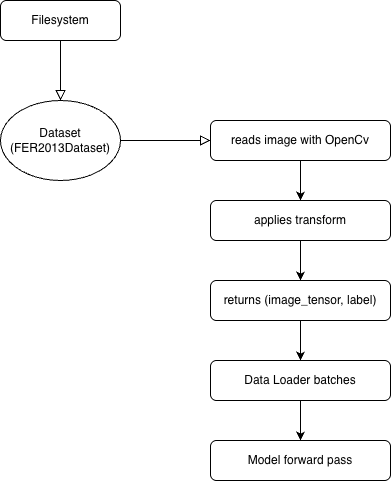
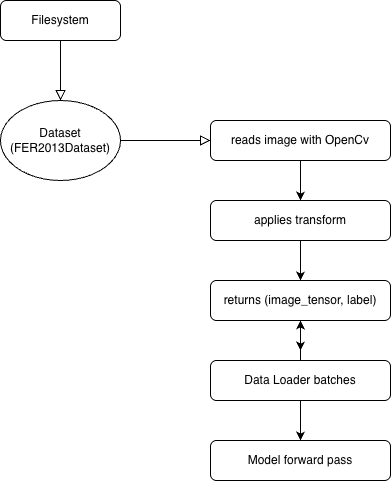

### Custom Dataset Loader

In [3]:
# custom dataset class
class FER2013Dataset(torch.utils.data.Dataset):
    """
    Custom class for loading the FER2013 emotion dataset

    Each subdirectory in `base_dir` represents one emotion class
    (e.g., 'happy', 'sad', 'neutral'), and contatins multiple grayscale face images
    of size roughly 48x48 pixels

    This class provides:
    - Automatic class label mapping (folder name = numeric index)
    - Image loading via OpenCV
    - Optional preprocessing and augmentation via tochvision transform
    """
    
    def __init__(self, base_dir, transform=None):
        """
        @input
            base dir (str): path to dataset root
            transform (callable, optional): torchvision transform pipeline to apply
        """
        self.base_dir = base_dir
        self.transform = transform
        self.samples = [] # list of (image_path, class_label) pairs
        self.classes = sorted(os.listdir(base_dir))

        # build list of all image paths + their corresponding numeric labels
        for label, cls in enumerate(self.classes):
            cls_dir = os.path.join(base_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(cls_dir, img_name), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        @return
            img (torch.Tensor): preprocessed img tensor [1, 48, 48]
            label (int): class inx corresponding to the emotion category
        """
        path, label = self.samples[idx]
        # img from disk -> 2D NumPy array
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48, 48))

        if self.transform:
            img = self.transform(img)

        return img, label

Now let's build a CustomAugment
Connecting it to the idea of building it production-ready and easy to extend later for full project (my own webcam data) let's think what augmentation we need:

- Rotation: small angles only (since webcam faces are mostly upright)
- Horizontal flips: yes, important to double the data nad simulate mirror orientation
- Brightness variation: realistic for webcam lighting changes
- No need for extreme rotations or zooms - could actually hurt generalization in this case

### Custom Augmentation

In [4]:
class CustomAugment:
    """
    Custom data augmentation tailored for webcam-based face emotion recognition

    It simulates realisitc variations:
        - Small head tilts (rotation)
        - Left/right mirroring
        - Lighting changes (brightness)
    """

    def __init__(self, rotation=15, flip_prob=0.5, brightness=0.2, brightness_prob=0.3):
        self.rotation = rotation
        self.flip_prob = flip_prob
        self.brightness = brightness
        self.brightness_prob = brightness_prob

    def __call__(self, img):
        """
        @input
            img (numpy.ndarray): grayscale img loaded via OpenCV
        @return
            PIL.Image: augmented img
        """
        img = Image.fromarray(img)

        angle = random.uniform(-self.rotation, self.rotation)
        img = transforms.functional.rotate(img, angle)

        if random.random() < self.flip_prob:
            img = transforms.functional.hflip(img)

        if random.random() < self.brightness_prob:
            factor = 1 + random.uniform(-self.brightness, self.brightness)
            img = transforms.functional.adjust_brightness(img, factor)

        return img

### Combine with Normalization and Compose

In [5]:
train_transform = transforms.Compose([
    CustomAugment(rotation=15, flip_prob=0.5, brightness=0.2, brightness_prob=0.35),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

### Quick Visualization

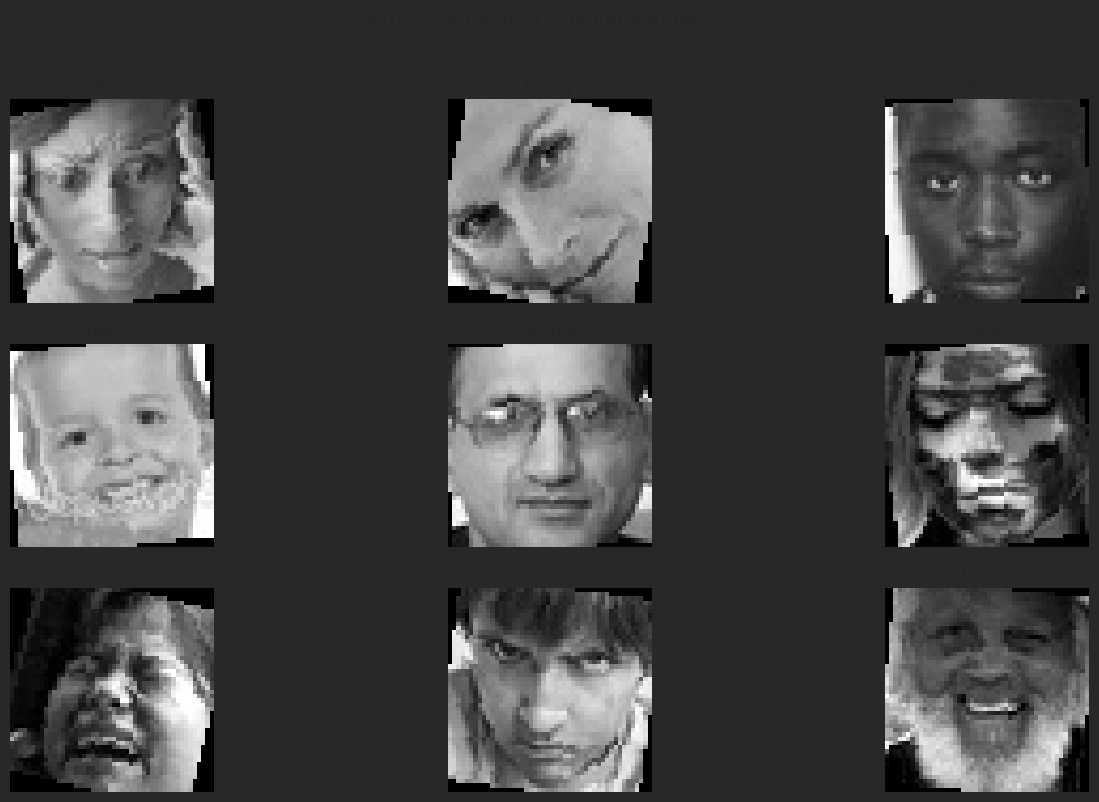

In [6]:
train_dataset = FER2013Dataset('/kaggle/input/fer2013/train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=9, shuffle=True) # wrap it

images, labels = next(iter(train_loader))
images = images * 0.5 + 0.5 # denormalize to [0, 1] for plotting

plt.figure(figsize=(16, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(train_dataset.classes[labels[i]])
    plt.axis('off')

plt.suptitle("Custom Augmented Training Samples", fontsize=14)
plt.show()

### Define Target Emotions

Since I am focusing only on 3 emotions, sad, happy and neutral, I want to remap everything that is not happy or sad into neutral.
That will balance my dataset better and make the model more robust to general expressions.
So let's quickly adjust dataset class accordingly:

In [7]:
# custom dataset class
class FER2013Dataset(torch.utils.data.Dataset):
    """
    Custom class for loading the FER2013 emotion dataset

    Each subdirectory in `base_dir` represents one emotion class
    (e.g., 'happy', 'sad', 'neutral'), and contatins multiple grayscale face images
    of size roughly 48x48 pixels

    We only want three classes to keep for training:
        0: Happy
        1: Sad
        2: Neutral (all other emotions)

    This class provides:
        - Automatic remapping of folder names to numeric labels
        - Image loading via OpenCV
        - Optional preprocessing and augmentation via torchvision transforms
    """
    
    def __init__(self, base_dir, transform=None):
        """
        @input
            base dir (str): path to dataset root
            transform (callable, optional): torchvision transform pipeline to apply
        """
        self.base_dir = base_dir
        self.transform = transform
        self.samples = [] # list of (image_path, class_label) pairs
        self.classes = sorted(os.listdir(base_dir))

        # build list of all image paths + remapped labels
        for cls in self.classes:
            cls_dir = os.path.join(base_dir, cls)
            if cls.lower() == "happy":
                label = 0
            elif cls.lower() == "sad":
                label = 1
            else:
                label = 2 # everything else = neutral

            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(cls_dir, img_name), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        @return
            img (torch.Tensor): preprocessed img tensor [1, 48, 48]
            label (int): class inx corresponding to the emotion category
        """
        path, label = self.samples[idx]
        
        # img from disk -> 2D NumPy array
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        # resize
        img = cv2.resize(img, (48, 48))

        if self.transform:
            img = self.transform(img)

        return img, label

### Compose Transforms

In [8]:
train_transform = transforms.Compose([
    CustomAugment(rotation=15, flip_prob=0.5, brightness=0.20, brightness_prob=0.35),
    # could add small extra torchvision augmentations later
    
    transforms.ToTensor(), # PIL -> tensor [C, H, W], scales [0..255] -> [0..1]
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

### Instantiate Dataset and Loaders

In [9]:
train_dataset = FER2013Dataset('/kaggle/input/fer2013/train', transform=train_transform)
test_dataset = FER2013Dataset('/kaggle/input/fer2013/test',  transform=test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Train size: 28709
Test size: 7178


Labels in this batch:
['Neutral', 'Sad', 'Sad', 'Neutral', 'Sad', 'Sad', 'Happy', 'Neutral', 'Happy']


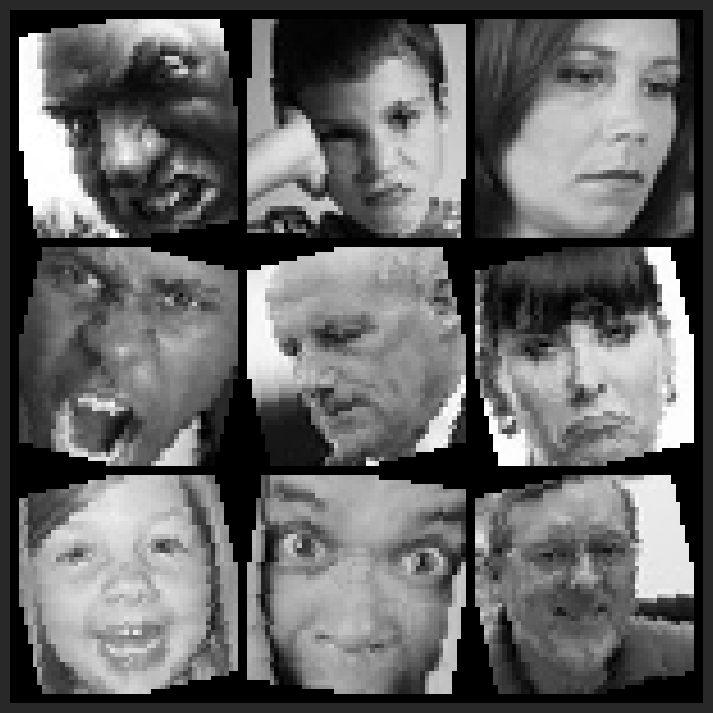

In [10]:
# Remapped label names
label_names = ["Happy", "Sad", "Neutral"]

def show_augmented_batch(loader, n=9):
    # grab first batch
    images, labels = next(iter(loader))
    
    images = images * 0.5 + 0.5  # denormalize to [0,1]

    # pick first n images and labels
    images = images[:n]
    labels = labels[:n]

    grid = torchvision.utils.make_grid(images, nrow=int(n**0.5), normalize=False)
    plt.figure(figsize=(16,9))
    plt.imshow(grid.permute(1,2,0).squeeze())
    plt.axis('off')

    # print labels below grid
    print("Labels in this batch:")
    print([label_names[label.item()] for label in labels])

    plt.show()

# Show a batch
show_augmented_batch(train_loader, n=9)

This approach is not perfect, but I feel like it will work for our usecase

## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Build Model</p>

Facial Expression Recognition (FER) is a common task in computer vision, and architectures have evolved significantly over the past decade. Modern solutions vary depending on dataset size and use case.

For this project, I will build a **Convolutional Neural Network (CNN)**:
- CNNs are designed for grid-like data (e.g., images), where **spatial hierarchies** matter.
- Convolutions enable **weight sharing** and **local receptive fields**, reducing parameters while capturing patterns like edges, textures, and facial features.
- Pooling layers reduce spatial resolution and improve **robustness to small translations**.
- Fast inference, especially for small-to-mid-size CNNs.
- Works well with small to medium datasets.
- Easy to deploy for **real-time webcam applications**.

### Alternatives Considered

1. **Transformers / Hybrid Models**  
   - Vision Transformers (ViTs) or CNN+Transformer hybrids capture **long-range dependencies** across the face.  
   - Often achieve higher accuracy on large-scale datasets.  
   - Flexible receptive field to model relationships across facial regions.  
   - Downsides: computationally heavier, require larger datasets or pretraining.

2. **Pretrained Models**  
   - Transfer learning is common: CNNs pretrained on ImageNet or FER datasets (e.g., AffectNet).  
   - Reduces training time and improves performance, especially on small datasets.  
   - Downsides: less educational/fun for personal projects, less hands-on experience building from scratch.

### Chosen Approach

- Build a **mid-size modern CNN** with **BatchNorm, Dropout, and Adaptive Pooling**.  
- Optimized for **48×48 grayscale images** and **real-time usage**.  
- Use **CustomAugment** to simulate real-world webcam conditions, to prepare for future fine-tuning on personal data.

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class MyCNN(nn.Module):
    """
    Mid-size CNN for 48x48 grayscale facial expression classification 3 output classes:
    Happy, Sad, Neutral
    """
    def __init__(self, num_classes=3):
        super().__init__()

        # -- Conv Blocks --
        # Hierarchical feature learning 
        # Conv Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # 48x48 -> 24x24
            nn.Dropout(0.1)
        )

        # Conv Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # 24x24 -> 12x12
            nn.Dropout(0.1)
        )

        # Conv block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # 12x12 -> 6x6
            nn.Dropout(0.25)
        )

        # Adaptive pooling to reduce to (1x1) features per channel
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    # forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.global_pool(x)
        x = self.fc(x)
        return x

Why we used **adaptive pooling**

Normal pooling (like MaxPool2d) reduces size by a **fixed kernel**, e.g. (2x2).
So our output size depends on input, if input changes, output changes. That's a problem for CNNs before fully-connected layers, because FC need **fixed-size** input

Thus we use AdaptiveAvgPool2d((1,1))

What it does is it takes feature map [B, 128, 6, 6], it becomes [B, 128, 1, 1], one value per channel, the average activation. Basically "summarize each feature map into one global feature strength."

So imagine each of the 128 feature maps in conv3 block is a "detector", one detects "smile intensity," another "eyebrow shift," another "how open the eye is."

AdaptiveAvgPool2d((1, 1)) compresses each detector's entire 2D map into a single avg value "How strongly was this features present across the face?" So say we have this [B (batch size), 128, 6, 6] AdaptiveAvgPool2d((1,1)) goes over each of the 128 feature maps separately
and averages all the 6×6 = 36 values inside it down to 1 single number. Thus we achive [B, 128, 1, 1].

Then we flatten it, getting [1, 128] **feature vectors**, one number per learned feature.

## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Train</p>

### Config

In [12]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0)/1024**3,1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0)/1024**3,1), "GB")

model = MyCNN().to(device)
num_epochs = 70
best_val_acc = 0.0

criterion = nn.CrossEntropyLoss()
# AdamW is generally more stable than Adam and supports weight decay properly
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
# Reduce LR when validation accuracy plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# TensorBoard writer for live monitoring
writer = SummaryWriter('runs/mimic_exp1')

2025-11-11 19:27:31.515057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762889251.696641      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762889251.749644      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Split Into train / val

In [13]:
from torch.utils.data import random_split

val_size = int(0.1 * len(train_dataset)) # 10% for val
train_size = len(train_dataset) - val_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Wrap them in DataLoader
train_loader = DataLoader(
    train_subset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_subset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

### Training Loop Skeleton

In [14]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    # Training Loop
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = total_loss / len(train_loader)

    # save losses for plots
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0.0

    # disable gradient computation here
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # save losses for plots
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Learning rate schedule
    scheduler.step(val_acc)

    # TensorBoard logging | not useful for kaggle env but good locally
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)
    writer.add_scalar("LR", optimizer.param_groups[0]['lr'], epoch)

    # Checkpointing model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} ")

writer.close()
torch.save(model, "fer_cnn_full_model.pth")

Epoch 1/70: 100%|██████████| 101/101 [01:31<00:00,  1.10it/s]


Epoch [1/70] Train Loss: 0.9431 | Train Acc: 0.5779 Val Loss: 0.9287 | Val Acc: 0.5944 


Epoch 2/70: 100%|██████████| 101/101 [00:18<00:00,  5.34it/s]


Epoch [2/70] Train Loss: 0.7736 | Train Acc: 0.6761 Val Loss: 0.7118 | Val Acc: 0.6930 


Epoch 3/70: 100%|██████████| 101/101 [00:18<00:00,  5.32it/s]


Epoch [3/70] Train Loss: 0.6980 | Train Acc: 0.7065 Val Loss: 0.7709 | Val Acc: 0.6787 


Epoch 4/70: 100%|██████████| 101/101 [00:19<00:00,  5.30it/s]


Epoch [4/70] Train Loss: 0.6704 | Train Acc: 0.7183 Val Loss: 0.6339 | Val Acc: 0.7317 


Epoch 5/70: 100%|██████████| 101/101 [00:19<00:00,  5.28it/s]


Epoch [5/70] Train Loss: 0.6454 | Train Acc: 0.7281 Val Loss: 0.6232 | Val Acc: 0.7387 


Epoch 6/70: 100%|██████████| 101/101 [00:20<00:00,  4.94it/s]


Epoch [6/70] Train Loss: 0.6287 | Train Acc: 0.7323 Val Loss: 0.6325 | Val Acc: 0.7383 


Epoch 7/70: 100%|██████████| 101/101 [00:19<00:00,  5.25it/s]


Epoch [7/70] Train Loss: 0.6153 | Train Acc: 0.7408 Val Loss: 0.7825 | Val Acc: 0.6666 


Epoch 8/70: 100%|██████████| 101/101 [00:19<00:00,  5.24it/s]


Epoch [8/70] Train Loss: 0.6080 | Train Acc: 0.7448 Val Loss: 0.6428 | Val Acc: 0.7348 


Epoch 9/70: 100%|██████████| 101/101 [00:21<00:00,  4.66it/s]


Epoch [9/70] Train Loss: 0.5970 | Train Acc: 0.7494 Val Loss: 0.5965 | Val Acc: 0.7467 


Epoch 10/70: 100%|██████████| 101/101 [00:19<00:00,  5.26it/s]


Epoch [10/70] Train Loss: 0.5877 | Train Acc: 0.7511 Val Loss: 0.5938 | Val Acc: 0.7509 


Epoch 11/70: 100%|██████████| 101/101 [00:18<00:00,  5.36it/s]


Epoch [11/70] Train Loss: 0.5828 | Train Acc: 0.7537 Val Loss: 0.6180 | Val Acc: 0.7453 


Epoch 12/70: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s]


Epoch [12/70] Train Loss: 0.5761 | Train Acc: 0.7544 Val Loss: 0.5763 | Val Acc: 0.7523 


Epoch 13/70: 100%|██████████| 101/101 [00:18<00:00,  5.40it/s]


Epoch [13/70] Train Loss: 0.5687 | Train Acc: 0.7586 Val Loss: 0.5955 | Val Acc: 0.7634 


Epoch 14/70: 100%|██████████| 101/101 [00:18<00:00,  5.35it/s]


Epoch [14/70] Train Loss: 0.5647 | Train Acc: 0.7613 Val Loss: 0.5819 | Val Acc: 0.7537 


Epoch 15/70: 100%|██████████| 101/101 [00:19<00:00,  5.22it/s]


Epoch [15/70] Train Loss: 0.5559 | Train Acc: 0.7633 Val Loss: 0.5466 | Val Acc: 0.7662 


Epoch 16/70: 100%|██████████| 101/101 [00:18<00:00,  5.46it/s]


Epoch [16/70] Train Loss: 0.5514 | Train Acc: 0.7640 Val Loss: 0.5964 | Val Acc: 0.7571 


Epoch 17/70: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s]


Epoch [17/70] Train Loss: 0.5482 | Train Acc: 0.7691 Val Loss: 0.5683 | Val Acc: 0.7544 


Epoch 18/70: 100%|██████████| 101/101 [00:18<00:00,  5.42it/s]


Epoch [18/70] Train Loss: 0.5408 | Train Acc: 0.7729 Val Loss: 0.5561 | Val Acc: 0.7620 


Epoch 19/70: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s]


Epoch [19/70] Train Loss: 0.5381 | Train Acc: 0.7724 Val Loss: 0.5598 | Val Acc: 0.7662 


Epoch 20/70: 100%|██████████| 101/101 [00:19<00:00,  5.21it/s]


Epoch [20/70] Train Loss: 0.5196 | Train Acc: 0.7793 Val Loss: 0.5283 | Val Acc: 0.7784 


Epoch 21/70: 100%|██████████| 101/101 [00:19<00:00,  5.31it/s]


Epoch [21/70] Train Loss: 0.5160 | Train Acc: 0.7817 Val Loss: 0.5759 | Val Acc: 0.7449 


Epoch 22/70: 100%|██████████| 101/101 [00:18<00:00,  5.52it/s]


Epoch [22/70] Train Loss: 0.5119 | Train Acc: 0.7857 Val Loss: 0.5591 | Val Acc: 0.7718 


Epoch 23/70: 100%|██████████| 101/101 [00:19<00:00,  5.25it/s]


Epoch [23/70] Train Loss: 0.5040 | Train Acc: 0.7858 Val Loss: 0.5192 | Val Acc: 0.7944 


Epoch 24/70: 100%|██████████| 101/101 [00:18<00:00,  5.47it/s]


Epoch [24/70] Train Loss: 0.5027 | Train Acc: 0.7890 Val Loss: 0.5471 | Val Acc: 0.7634 


Epoch 25/70: 100%|██████████| 101/101 [00:18<00:00,  5.44it/s]


Epoch [25/70] Train Loss: 0.5013 | Train Acc: 0.7879 Val Loss: 0.5318 | Val Acc: 0.7676 


Epoch 26/70: 100%|██████████| 101/101 [00:18<00:00,  5.42it/s]


Epoch [26/70] Train Loss: 0.4974 | Train Acc: 0.7911 Val Loss: 0.5677 | Val Acc: 0.7373 


Epoch 27/70: 100%|██████████| 101/101 [00:18<00:00,  5.40it/s]


Epoch [27/70] Train Loss: 0.4957 | Train Acc: 0.7910 Val Loss: 0.5139 | Val Acc: 0.7805 


Epoch 28/70: 100%|██████████| 101/101 [00:18<00:00,  5.50it/s]


Epoch [28/70] Train Loss: 0.4844 | Train Acc: 0.7976 Val Loss: 0.5083 | Val Acc: 0.7875 


Epoch 29/70: 100%|██████████| 101/101 [00:19<00:00,  5.28it/s]


Epoch [29/70] Train Loss: 0.4822 | Train Acc: 0.7955 Val Loss: 0.5341 | Val Acc: 0.7822 


Epoch 30/70: 100%|██████████| 101/101 [00:18<00:00,  5.37it/s]


Epoch [30/70] Train Loss: 0.4790 | Train Acc: 0.8007 Val Loss: 0.5125 | Val Acc: 0.7882 


Epoch 31/70: 100%|██████████| 101/101 [00:18<00:00,  5.42it/s]


Epoch [31/70] Train Loss: 0.4761 | Train Acc: 0.8011 Val Loss: 0.5137 | Val Acc: 0.7718 


Epoch 32/70: 100%|██████████| 101/101 [00:18<00:00,  5.55it/s]


Epoch [32/70] Train Loss: 0.4715 | Train Acc: 0.7999 Val Loss: 0.5004 | Val Acc: 0.7878 


Epoch 33/70: 100%|██████████| 101/101 [00:19<00:00,  5.23it/s]


Epoch [33/70] Train Loss: 0.4679 | Train Acc: 0.8042 Val Loss: 0.5126 | Val Acc: 0.7906 


Epoch 34/70: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s]


Epoch [34/70] Train Loss: 0.4648 | Train Acc: 0.8048 Val Loss: 0.4943 | Val Acc: 0.7941 


Epoch 35/70: 100%|██████████| 101/101 [00:18<00:00,  5.43it/s]


Epoch [35/70] Train Loss: 0.4659 | Train Acc: 0.8044 Val Loss: 0.5015 | Val Acc: 0.7962 


Epoch 36/70: 100%|██████████| 101/101 [00:18<00:00,  5.51it/s]


Epoch [36/70] Train Loss: 0.4641 | Train Acc: 0.8034 Val Loss: 0.4901 | Val Acc: 0.7892 


Epoch 37/70: 100%|██████████| 101/101 [00:20<00:00,  4.95it/s]


Epoch [37/70] Train Loss: 0.4625 | Train Acc: 0.8077 Val Loss: 0.4956 | Val Acc: 0.7902 


Epoch 38/70: 100%|██████████| 101/101 [00:18<00:00,  5.35it/s]


Epoch [38/70] Train Loss: 0.4609 | Train Acc: 0.8077 Val Loss: 0.4960 | Val Acc: 0.7889 


Epoch 39/70: 100%|██████████| 101/101 [00:19<00:00,  5.26it/s]


Epoch [39/70] Train Loss: 0.4606 | Train Acc: 0.8075 Val Loss: 0.5021 | Val Acc: 0.7885 


Epoch 40/70: 100%|██████████| 101/101 [00:20<00:00,  5.00it/s]


Epoch [40/70] Train Loss: 0.4562 | Train Acc: 0.8079 Val Loss: 0.4931 | Val Acc: 0.7902 


Epoch 41/70: 100%|██████████| 101/101 [00:19<00:00,  5.25it/s]


Epoch [41/70] Train Loss: 0.4531 | Train Acc: 0.8097 Val Loss: 0.4935 | Val Acc: 0.7913 


Epoch 42/70: 100%|██████████| 101/101 [00:19<00:00,  5.28it/s]


Epoch [42/70] Train Loss: 0.4527 | Train Acc: 0.8109 Val Loss: 0.5032 | Val Acc: 0.7895 


Epoch 43/70: 100%|██████████| 101/101 [00:18<00:00,  5.33it/s]


Epoch [43/70] Train Loss: 0.4527 | Train Acc: 0.8132 Val Loss: 0.5051 | Val Acc: 0.7826 


Epoch 44/70: 100%|██████████| 101/101 [00:18<00:00,  5.41it/s]


Epoch [44/70] Train Loss: 0.4545 | Train Acc: 0.8100 Val Loss: 0.4975 | Val Acc: 0.7882 


Epoch 45/70: 100%|██████████| 101/101 [00:19<00:00,  5.30it/s]


Epoch [45/70] Train Loss: 0.4538 | Train Acc: 0.8126 Val Loss: 0.4887 | Val Acc: 0.7923 


Epoch 46/70: 100%|██████████| 101/101 [00:18<00:00,  5.38it/s]


Epoch [46/70] Train Loss: 0.4483 | Train Acc: 0.8133 Val Loss: 0.5032 | Val Acc: 0.7899 


Epoch 47/70: 100%|██████████| 101/101 [00:19<00:00,  5.23it/s]


Epoch [47/70] Train Loss: 0.4496 | Train Acc: 0.8130 Val Loss: 0.4953 | Val Acc: 0.7934 


Epoch 48/70: 100%|██████████| 101/101 [00:20<00:00,  4.84it/s]


Epoch [48/70] Train Loss: 0.4490 | Train Acc: 0.8119 Val Loss: 0.4974 | Val Acc: 0.7909 


Epoch 49/70: 100%|██████████| 101/101 [00:22<00:00,  4.58it/s]


Epoch [49/70] Train Loss: 0.4453 | Train Acc: 0.8123 Val Loss: 0.4862 | Val Acc: 0.7969 


Epoch 50/70: 100%|██████████| 101/101 [00:20<00:00,  5.03it/s]


Epoch [50/70] Train Loss: 0.4496 | Train Acc: 0.8127 Val Loss: 0.4923 | Val Acc: 0.7941 


Epoch 51/70: 100%|██████████| 101/101 [00:20<00:00,  5.02it/s]


Epoch [51/70] Train Loss: 0.4503 | Train Acc: 0.8118 Val Loss: 0.5022 | Val Acc: 0.7850 


Epoch 52/70: 100%|██████████| 101/101 [00:19<00:00,  5.24it/s]


Epoch [52/70] Train Loss: 0.4466 | Train Acc: 0.8121 Val Loss: 0.5120 | Val Acc: 0.7969 


Epoch 53/70: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s]


Epoch [53/70] Train Loss: 0.4490 | Train Acc: 0.8126 Val Loss: 0.4957 | Val Acc: 0.7885 


Epoch 54/70: 100%|██████████| 101/101 [00:19<00:00,  5.21it/s]


Epoch [54/70] Train Loss: 0.4509 | Train Acc: 0.8096 Val Loss: 0.5072 | Val Acc: 0.7916 


Epoch 55/70: 100%|██████████| 101/101 [00:19<00:00,  5.24it/s]


Epoch [55/70] Train Loss: 0.4488 | Train Acc: 0.8137 Val Loss: 0.4994 | Val Acc: 0.7909 


Epoch 56/70: 100%|██████████| 101/101 [00:20<00:00,  4.93it/s]


Epoch [56/70] Train Loss: 0.4458 | Train Acc: 0.8118 Val Loss: 0.4945 | Val Acc: 0.7923 


Epoch 57/70: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s]


Epoch [57/70] Train Loss: 0.4442 | Train Acc: 0.8163 Val Loss: 0.4928 | Val Acc: 0.7955 


Epoch 58/70: 100%|██████████| 101/101 [00:19<00:00,  5.23it/s]


Epoch [58/70] Train Loss: 0.4455 | Train Acc: 0.8146 Val Loss: 0.4884 | Val Acc: 0.7871 


Epoch 59/70: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s]


Epoch [59/70] Train Loss: 0.4423 | Train Acc: 0.8161 Val Loss: 0.4999 | Val Acc: 0.7983 


Epoch 60/70: 100%|██████████| 101/101 [00:19<00:00,  5.30it/s]


Epoch [60/70] Train Loss: 0.4494 | Train Acc: 0.8126 Val Loss: 0.5211 | Val Acc: 0.7916 


Epoch 61/70: 100%|██████████| 101/101 [00:20<00:00,  4.87it/s]


Epoch [61/70] Train Loss: 0.4494 | Train Acc: 0.8113 Val Loss: 0.5014 | Val Acc: 0.7889 


Epoch 62/70: 100%|██████████| 101/101 [00:19<00:00,  5.27it/s]


Epoch [62/70] Train Loss: 0.4424 | Train Acc: 0.8143 Val Loss: 0.4761 | Val Acc: 0.7951 


Epoch 63/70: 100%|██████████| 101/101 [00:19<00:00,  5.31it/s]


Epoch [63/70] Train Loss: 0.4435 | Train Acc: 0.8168 Val Loss: 0.4886 | Val Acc: 0.7916 


Epoch 64/70: 100%|██████████| 101/101 [00:18<00:00,  5.41it/s]


Epoch [64/70] Train Loss: 0.4473 | Train Acc: 0.8126 Val Loss: 0.4978 | Val Acc: 0.7864 


Epoch 65/70: 100%|██████████| 101/101 [00:18<00:00,  5.39it/s]


Epoch [65/70] Train Loss: 0.4489 | Train Acc: 0.8128 Val Loss: 0.4891 | Val Acc: 0.7930 


Epoch 66/70: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s]


Epoch [66/70] Train Loss: 0.4470 | Train Acc: 0.8139 Val Loss: 0.4910 | Val Acc: 0.7962 


Epoch 67/70: 100%|██████████| 101/101 [00:23<00:00,  4.31it/s]


Epoch [67/70] Train Loss: 0.4473 | Train Acc: 0.8152 Val Loss: 0.4902 | Val Acc: 0.7955 


Epoch 68/70: 100%|██████████| 101/101 [00:23<00:00,  4.36it/s]


Epoch [68/70] Train Loss: 0.4448 | Train Acc: 0.8144 Val Loss: 0.4908 | Val Acc: 0.8000 


Epoch 69/70: 100%|██████████| 101/101 [00:22<00:00,  4.52it/s]


Epoch [69/70] Train Loss: 0.4434 | Train Acc: 0.8129 Val Loss: 0.4929 | Val Acc: 0.7906 


Epoch 70/70: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s]


Epoch [70/70] Train Loss: 0.4428 | Train Acc: 0.8144 Val Loss: 0.5075 | Val Acc: 0.7854 


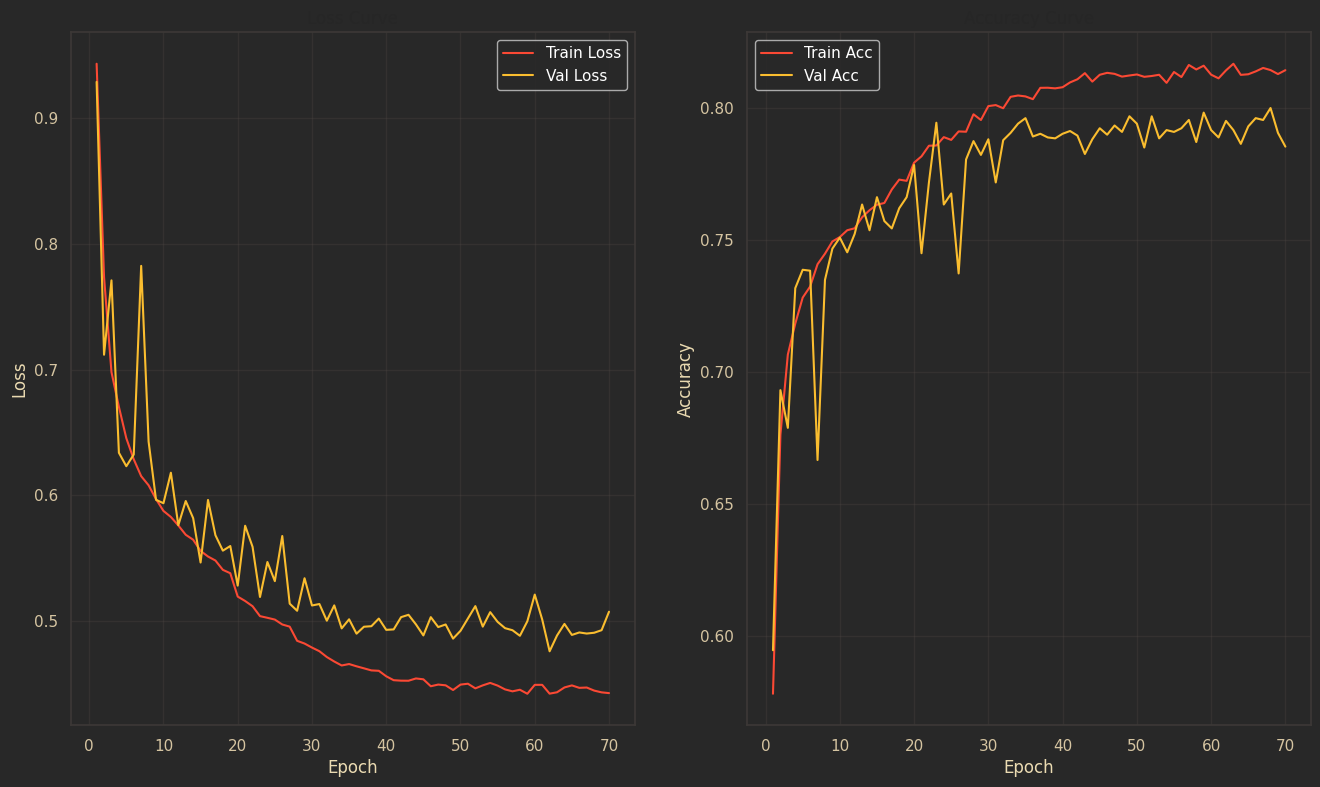

In [15]:
epochs = range(1, num_epochs+1)

# Loss curve
plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend( labelcolor='white')

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend( labelcolor='white')

plt.show()

In [16]:
# %load_ext tensorboard
# %tensorboard --logdir=/kaggle/working/runs/mimic_exp1

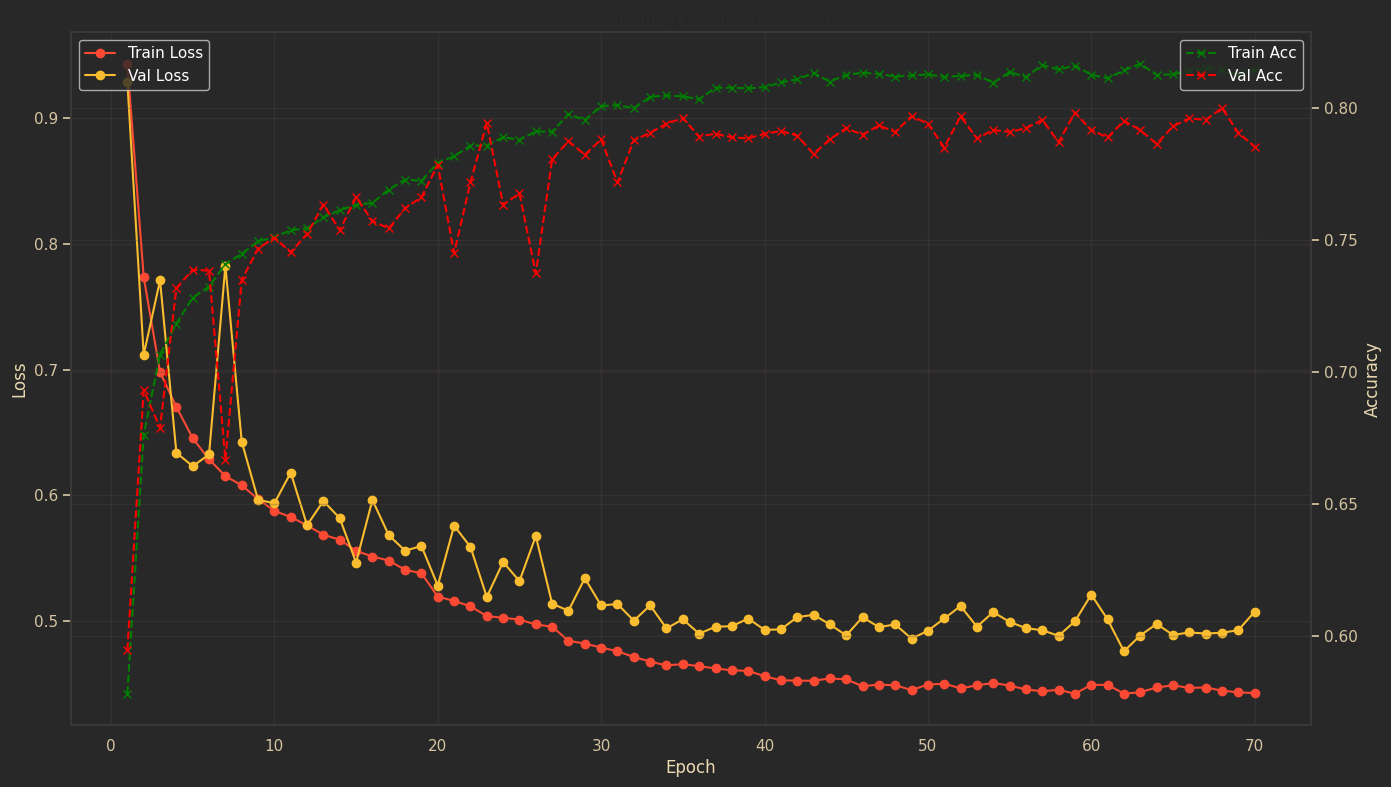

In [17]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def plot_fer_training_curves(log_dir="/kaggle/working/runs/mimic_exp1"):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # Scalars
    train_loss_events = event_acc.Scalars('Loss/train')
    val_loss_events = event_acc.Scalars('Loss/val')
    train_acc_events = event_acc.Scalars('Accuracy/train')
    val_acc_events = event_acc.Scalars('Accuracy/val')

    # Steps (x-axis = epoch number)
    epochs = [e.step+1 for e in train_loss_events]  # assuming step=epoch index starting from 0

    # Values
    train_loss = [e.value for e in train_loss_events]
    val_loss   = [e.value for e in val_loss_events]
    train_acc  = [e.value for e in train_acc_events]
    val_acc    = [e.value for e in val_acc_events]

    # Create figure
    fig, ax1 = plt.subplots(figsize=(16,9))

    # Loss curves
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(epochs, train_loss, label="Train Loss", marker='o')
    ax1.plot(epochs, val_loss, label="Val Loss", marker='o')
    ax1.legend(loc='upper left',  labelcolor='white')

    # Accuracy on secondary axis
    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    ax2.plot(epochs, train_acc, label="Train Acc", linestyle='--', marker='x', color='green')
    ax2.plot(epochs, val_acc, label="Val Acc", linestyle='--', marker='x', color='red')
    ax2.legend(loc='upper right',  labelcolor='white')

    plt.title("FER CNN Training & Validation Curves")
    plt.show()

# Call the function
plot_fer_training_curves()

In [18]:
model.eval()
with torch.no_grad():
    imgs, labels = next(iter(test_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    _, preds = torch.max(outputs, 1)

# Print a few predictions
for i in range(5):
    print("Predicted:", preds[i].item(), "Ground truth:", labels[i].item())

Predicted: 2 Ground truth: 0
Predicted: 1 Ground truth: 2
Predicted: 1 Ground truth: 1
Predicted: 0 Ground truth: 2
Predicted: 2 Ground truth: 2
